# GISTDA Wildfire Machine Learning Training

### This project is focused on developing and training machine learning models to predict and monitor wildfires. It utilizes datasets from Sentinel-2 Images as Raster GeoTIFF format which have been wildfire extraction, analyzes environmental factors, and applies machine learning algorithms to enhance prediction performance.

## Import Library Package

##### 1. **Numpy (`numpy`)**
   - **Description**: A powerful library for numerical computations in Python. It provides support for arrays, matrices, and a large collection of mathematical functions to operate on these data structures, making it essential for scientific and statistical analysis.

##### 2. **Pandas (`pandas`)**
   - **Description**: A widely-used library for data manipulation and analysis. It provides data structures such as DataFrames to store and manipulate large datasets, making data cleaning, transformation, and exploration more efficient and intuitive.

##### 3. **Matplotlib (`matplotlib.pyplot`)**
   - **Description**: A plotting library that provides tools for creating a wide range of static, animated, and interactive visualizations in Python. It is commonly used for generating graphs, charts, and other visual data representations.

##### 4. **Seaborn (`seaborn`)**
   - **Description**: A statistical data visualization library built on top of Matplotlib. It offers high-level functions for creating informative and attractive visualizations, especially useful for exploring and understanding data trends and distributions.

##### 5. **OS (`os`)**
   - **Description**: A standard library in Python that provides functions to interact with the operating system, allowing you to work with directories, files, and system paths. It's useful for handling file operations, environment variables, and system commands.

##### 6. **Pickle (`pickle`)**
   - **Description**: A Python module used to serialize and deserialize Python objects, allowing you to save complex data structures to files and load them back into your program. It’s commonly used for saving trained models or intermediate data states.

##### 7. **Dask (`dask.dataframe` and `dask`)**
   - **Description**: A parallel computing library that scales up computations on larger datasets. `dask.dataframe` provides similar functionality to Pandas DataFrames but can handle larger-than-memory data by performing parallel, chunked computations.

##### 8. **Rasterio (`rasterio`)**
   - **Description**: A library for reading and writing geospatial raster data. It’s widely used for working with geospatial data in formats like GeoTIFF, allowing for operations on large image files commonly used in remote sensing and GIS applications.

##### 9. **Scikit-Learn (`sklearn`)**
   - **Description**: A robust library for machine learning that provides simple and efficient tools for data analysis and modeling. It includes modules like `MinMaxScaler` for scaling data, `cross_val_score` and `cross_val_predict` for evaluating models, and various classifiers.

##### 10. **LightGBM (`lightgbm`)**
   - **Description**: A high-performance, gradient-boosting framework developed by Microsoft. It's optimized for speed and efficiency on large datasets and is particularly well-suited for structured data and classification problems.

##### 11. **IPython (`IPython.display`)**
   - **Description**: A library for creating interactive elements in Jupyter Notebooks, such as displaying Markdown, HTML, and other rich content. It’s often used to improve the readability and interactivity of notebook outputs.

##### 12. **Delayed and Compute (`dask.delayed` and `dask.compute`)**
   - **Description**: Functions in the Dask library that allow you to parallelize and execute tasks asynchronously. `delayed` is used to mark a function for lazy evaluation, and `compute` is used to execute the delayed functions, making computations efficient and scalable.

##### 13. **Rasterio Windows (`rasterio.windows`)**
   - **Description**: A submodule in Rasterio that allows for windowed or tiled reading of raster data. This is useful for reading and processing only portions of large raster datasets, improving efficiency when working with large geospatial files.

##### 14. **XGBoost (`xgboost`)**
   - **Description**: An optimized gradient-boosting framework that’s highly effective for predictive modeling tasks, especially classification and regression. It’s known for its speed and performance and is widely used in machine learning competitions for its accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import dask.dataframe as dd
import rasterio
import dask
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from IPython.display import display, Markdown
from dask import delayed, compute
from rasterio.windows import Window
from xgboost import XGBClassifier

## Import Raster GeoTIFF files

This code reads large raster files in manageable chunks, processes each chunk, and stores the data in a consolidated DataFrame.

1. **Folder Path and Chunk Size**: Sets the path to the folder containing raster files (`raster_train_file_path`) and defines the chunk size (`CHUNK_SIZE`).

2. **`read_raster_in_chunks` Function**:
   - Reads a raster file chunk-by-chunk.
   - For each chunk, it extracts data from all bands, along with the pixel coordinates.
   - Stores each chunk's data in a temporary DataFrame, which is added to a list.

3. **Task Creation**:
   - Creates a list of tasks using Dask's `@delayed` to process each raster file in parallel.

4. **Compute and Combine**:
   - Computes each task to get individual DataFrames for each file, then combines them into a final DataFrame (`final_df`).

5. **Debug Outputs**:
   - Prints the shape, columns, and a sample of the final DataFrame for inspection.

In [2]:
# Define the folder containing the raster files
raster_train_file_path = r'Raster_Train'

# Parameters for chunk size
CHUNK_SIZE = 512 # Adjust following your hardware specification

@delayed
def read_raster_in_chunks(raster_path, file, root):
    with rasterio.open(raster_path) as src:
        height, width = src.height, src.width
        num_bands = src.count
        band_names = [f'B{str(i).zfill(2)}' for i in range(1, num_bands + 1)]
        chunk_dfs = []
        
        # Loop over the raster in chunks
        for row in range(0, height, CHUNK_SIZE):
            for col in range(0, width, CHUNK_SIZE):
                window = Window(col_off=col, row_off=row, 
                              width=min(CHUNK_SIZE, width - col),
                              height=min(CHUNK_SIZE, height - row))
                
                # Read all bands at once
                data = src.read(window=window)
                
                # Check if chunk contains any data
                if np.any(data):
                    rows, cols = data[0].shape
                    
                    # Create base DataFrame with coordinates
                    row_coords, col_coords = np.meshgrid(
                        np.arange(row, row + rows),
                        np.arange(col, col + cols),
                        indexing="ij"
                    )
                    
                    chunk_df = pd.DataFrame({
                        'raster_file': file,
                        'subfolder': os.path.basename(root),
                        'x': row_coords.flatten(),
                        'y': col_coords.flatten()
                    })
                    
                    # Add each band's data
                    for band_idx, band_name in enumerate(band_names, 1):
                        chunk_df[band_name] = data[band_idx-1].flatten()
                    
                    chunk_dfs.append(chunk_df)
        
        return pd.concat(chunk_dfs, ignore_index=True) if chunk_dfs else pd.DataFrame()

# Create list of tasks
dask_dfs = [
    read_raster_in_chunks(os.path.join(root, file), file, root)
    for root, dirs, files in os.walk(raster_train_file_path)
    for file in files if file.endswith('.tif')
]

# Compute all tasks
dataframes = compute(*dask_dfs)

# Combine all DataFrames
final_df = pd.concat(dataframes, ignore_index=True)

# Debug prints
print("DataFrame shape:", final_df.shape)
print("\nDataFrame columns:", final_df.columns.tolist())
print("\nSample of data:")
print(final_df.head())

DataFrame shape: (279379968, 18)

DataFrame columns: ['raster_file', 'subfolder', 'x', 'y', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14']

Sample of data:
                                  raster_file     subfolder  x  y     B01  \
0  T46QFG_20250310T040549_chunk_1792_5376.tif  Raster_Train  0  0  1712.0   
1  T46QFG_20250310T040549_chunk_1792_5376.tif  Raster_Train  0  1  1751.0   
2  T46QFG_20250310T040549_chunk_1792_5376.tif  Raster_Train  0  2  1789.0   
3  T46QFG_20250310T040549_chunk_1792_5376.tif  Raster_Train  0  3  1808.0   
4  T46QFG_20250310T040549_chunk_1792_5376.tif  Raster_Train  0  4  1806.0   

      B02     B03     B04     B05     B06     B07     B08     B09     B10  \
0  1838.0  1598.0  2226.0  4721.0  5595.0  5721.0  6271.0  3500.0  2127.0   
1  1858.0  1618.0  2226.0  4721.0  5595.0  5677.0  6271.0  3500.0  2127.0   
2  1852.0  1626.0  2331.0  4467.0  5692.0  5572.0  5881.0  3305.0  2074.0   
3  1906.0  1678.0  233

## Exploratory Data Analysis (EDA) & Feature Engineering

This code performs several operations on a DataFrame (`final_df`), converting it to a Dask DataFrame for distributed processing, renaming columns, and dropping unnecessary columns:

1. **Convert to Dask DataFrame**:
   - Converts the existing Pandas DataFrame (`final_df`) into a Dask DataFrame (`ddf`) to enable parallel, distributed processing.

2. **Rename Columns**:
   - Defines a list of new column names for Sentinel-2 bands and other data (`new_col_names`).
   - Renames `ddf` columns using this list to make them more descriptive.

3. **Drop Unneeded Columns**:
   - Drops columns such as `raster_file`, `subfolder`, `x`, `y`, and `dNBR`, keeping only essential information in the DataFrame (`df`).

4. **Display DataFrame**:
   - Uses `display()` to view the DataFrame when needed, triggering Dask's computation.

In [3]:
# Rename columns
new_col_names = ['raster_file', 'subfolder', 'x', 'y', 'Band_2', 'Band_3', 'Band_4', 
                 'Band_5', 'Band_6', 'Band_7', 'Band_8', 'Band_8A', 'Band_11', 
                 'Band_12', 'dNBR', 'NDVI', 'NDWI', 'Burn_Label']
df = final_df.rename(columns=dict(zip(final_df.columns, new_col_names)))

# Drop unnecessary columns
columns_to_drop = ['raster_file', 'subfolder', 'x', 'y', 'dNBR']
df = df.drop(columns=columns_to_drop)

# Display DataFrame (computing results)
print(df.head())  # Displays a small, computed sample

   Band_2  Band_3  Band_4  Band_5  Band_6  Band_7  Band_8  Band_8A  Band_11  \
0  1712.0  1838.0  1598.0  2226.0  4721.0  5595.0  5721.0   6271.0   3500.0   
1  1751.0  1858.0  1618.0  2226.0  4721.0  5595.0  5677.0   6271.0   3500.0   
2  1789.0  1852.0  1626.0  2331.0  4467.0  5692.0  5572.0   5881.0   3305.0   
3  1808.0  1906.0  1678.0  2331.0  4467.0  5692.0  5352.0   5881.0   3305.0   
4  1806.0  1960.0  1662.0  2336.0  4321.0  5271.0  5552.0   5519.0   3333.0   

   Band_12      NDVI      NDWI  Burn_Label  
0   2127.0  0.563328 -0.513692         0.0  
1   2127.0  0.556409 -0.506835         0.0  
2   2074.0  0.548208 -0.501078         0.0  
3   2074.0  0.522617 -0.474786         0.0  
4   2086.0  0.539229 -0.478168         0.0  


### Check Burn Class

This code checks and displays the counts of burn records in the DataFrame:

1. **Count Burn Labels**:
   - Counts occurrences in the `Burn_Label` column to determine the number of "Burn" and "Unburn" records.
   - Renames the labels: `1` to "Burn" and `0` to "Unburn" for readability.

2. **Display Counts**:
   - Prints the resulting counts to show the distribution of burn and unburned areas.

In [4]:
# Check Burn Records
burn_counts = df['Burn_Label'].value_counts().rename(index={1: 'Burn', 0: 'Unburn'})

# Display the counts with labels
print(burn_counts)

Burn_Label
Unburn    257421141
Burn       21958827
Name: count, dtype: int64


### Downsampling

This code performs downsampling to balance the dataset by reducing the number of "Unburn" records to match the count of "Burn" records:

1. **Get Burn Count**:
   - Retrieves the count of "Burn" records from `burn_counts`.

2. **Sample Unburned Records**:
   - Selects a random sample of "Unburn" records, equal in size to the number of "Burn" records, using a fixed `random_state` for reproducibility.

3. **Combine Burn and Downsampled Unburn Records**:
   - Combines all "Burn" records with the downsampled "Unburn" sample into a new DataFrame (`downsampled_df`).

4. **Check New Burn Record Counts**:
   - Counts and displays the "Burn" and "Unburn" records in `downsampled_df` to verify balance.

In [5]:
burn_count = burn_counts['Burn']
unburn_sample = df[df['Burn_Label'] == 0].sample(n=burn_count, random_state=42)

downsampled_df = pd.concat([df[df['Burn_Label'] == 1], unburn_sample])

# Check Burn Records
burn_counts = downsampled_df['Burn_Label'].value_counts().rename(index={1: 'Burn', 0: 'Unburn'})

# Display the counts with labels
print(burn_counts)

Burn_Label
Burn      21958827
Unburn    21958827
Name: count, dtype: int64


## Pre-Processing

### Remove infinite values

This code handles the presence of infinite values and missing data in the `downsampled_df` DataFrame:

1. **Replace Infinite Values**:
   - Replaces both positive and negative infinite values (`np.inf` and `-np.inf`) with `NaN` using `replace()`. This ensures that infinite values do not interfere with further processing.

2. **Drop Rows with Missing Values**:
   - Removes any rows containing `NaN` values using `dropna()`, ensuring the DataFrame only contains valid data.

3. **Display the DataFrame**:
   - Displays the cleaned DataFrame (`downsampled_df`) for inspection.

In [6]:
# Replacing infinite with nan 
downsampled_df.replace([np.inf, -np.inf], np.nan, inplace=True) 
  
# Dropping all the rows with nan values 
downsampled_df.dropna(inplace=True)

# Printing df 
display(downsampled_df)

,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_11,Band_12,NDVI,NDWI,Burn_Label
499,1740.0,1820.0,1971.0,2190.0,2338.0,2475.0,2480.0,2572.0,3077.0,2733.0,0.114356,-0.153488,1.0
500,1674.0,1754.0,1884.0,2105.0,2245.0,2341.0,2366.0,2470.0,2940.0,2522.0,0.113412,-0.148544,1.0
501,1683.0,1764.0,1907.0,2105.0,2245.0,2341.0,2365.0,2470.0,2940.0,2522.0,0.107210,-0.145556,1.0
997,1689.0,1718.0,1852.0,2110.0,2302.0,2438.0,2353.0,2632.0,3224.0,2748.0,0.119144,-0.155981,1.0
1011,1722.0,1812.0,1957.0,2190.0,2338.0,2475.0,2476.0,2572.0,3077.0,2733.0,0.117076,-0.154851,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162866353,1520.0,1660.0,1761.0,2027.0,2017.0,2094.0,2193.0,2184.0,1821.0,1629.0,0.109256,-0.138334,0.0
69612752,1686.0,2116.0,2410.0,2190.0,3120.0,3565.0,3664.0,3609.0,2764.0,2192.0,0.206454,-0.267820,0.0
16304459,1830.0,2186.0,2584.0,2998.0,3167.0,3403.0,3512.0,3793.0,4874.0,3885.0,0.152231,-0.232713,0.0
30343306,1838.0,2160.0,2588.0,2842.0,3066.0,3304.0,3418.0,3579.0,4552.0,3635.0,0.138195,-0.225529,0.0


### Seperate Burn_Label from DataFrame

This code separates the `Burn_Label` from the main DataFrame and ensures the label is in the correct format:

1. **Separate Burn Label**:
   - Extracts the `Burn_Label` column from `downsampled_df` into a new DataFrame (`burn_label`).

2. **Remove Burn Label from Main DataFrame**:
   - Drops the `Burn_Label` column from `downsampled_df` to ensure only the feature data remains.

3. **Convert Burn Label to Integer**:
   - Changes the data type of the `burn_label` DataFrame to `int32` to ensure consistent and efficient processing.

4. **Display Burn Label**:
   - Displays the modified `burn_label` DataFrame to verify the changes.

In [7]:
# Seperate Burn_Label from DataFrame
burn_label = downsampled_df[['Burn_Label']]

# Drop Label from DataFrame
downsampled_df = downsampled_df.drop(columns=['Burn_Label'])

# Change type of Label to Integer Format
burn_label = burn_label.astype('int32')
display(burn_label)

,Burn_Label
499,1
500,1
501,1
997,1
1011,1
...,...
162866353,0
69612752,0
16304459,0
30343306,0


### Normalization Data with MinMax Scaler

This code normalizes the feature data and saves the normalization model, while also combining it with the `Burn_Label`:

1. **List Columns**:
   - Creates a list of column names from `downsampled_df` to keep track of the column order after normalization (`cols_norm`).

2. **Normalize the Data**:
   - Imports `MinMaxScaler` from `sklearn` and fits it to the data in `downsampled_df`, which scales the values between 0 and 1.

3. **Save the Scaler**:
   - Saves the fitted `MinMaxScaler` model to a specified path (`MinMax_Scaler.pkl`) for later use.

4. **Apply Normalization**:
   - Normalizes the data by applying the `scaler` to `downsampled_df`, then converts the result back into a DataFrame (`df_norm`) with the original column names.

5. **Check Shape**:
   - Prints the shape of `df_norm` to confirm the normalization was applied correctly.

6. **Concatenate with Burn Label**:
   - Combines the normalized feature data (`df_norm`) with the `burn_label` DataFrame, aligning them by their indices and ensuring the result is a complete dataset.

7. **Display the DataFrame**:
   - Displays the final DataFrame (`df_norm`), which now includes both the normalized features and the `Burn_Label`.


In [8]:
# Reassign the dataframe with a list of the columns
cols_norm = downsampled_df.columns.tolist()

# Import Normalize technique
scaler = MinMaxScaler()

# Normalize data
scaler.fit(downsampled_df)

# Save the scaler
scaler_save_path = r'Export_Model'
save_path = os.path.join(scaler_save_path, 'MinMax_Scaler.pkl')
os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, 'wb') as f:
    pickle.dump(scaler, f)

# Normalize Data
df_norm = scaler.transform(downsampled_df)
df_norm = pd.DataFrame(df_norm, columns=cols_norm)

# Check df_norm shape after normalization
print("Shape of df_norm after normalization:", df_norm.shape)

# Concatenate df_norm with burn_label
df_norm = pd.concat([df_norm.reset_index(drop=True), burn_label.reset_index(drop=True)], axis=1, sort=False)
display(df_norm)

Shape of df_norm after normalization: (43917654, 12)


,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_8A,Band_11,Band_12,NDVI,NDWI,Burn_Label
0,0.044140,0.039102,0.097151,0.109520,0.114984,0.127848,0.133736,0.127379,0.134688,0.116817,0.557178,0.307784,1
1,0.041381,0.035989,0.092863,0.105093,0.110095,0.120698,0.127588,0.121703,0.126125,0.103407,0.556706,0.310752,1
2,0.041757,0.036461,0.093996,0.105093,0.110095,0.120698,0.127535,0.121703,0.126125,0.103407,0.553605,0.312545,1
3,0.042008,0.034291,0.091285,0.105354,0.113091,0.125874,0.126887,0.130718,0.143875,0.117770,0.559572,0.306288,1
4,0.043387,0.038725,0.096461,0.109520,0.114984,0.127848,0.133520,0.127379,0.134688,0.116817,0.558538,0.306967,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43917649,0.034944,0.031555,0.086800,0.101031,0.098107,0.107518,0.118259,0.105787,0.056188,0.046651,0.554628,0.316879,0
43917650,0.041883,0.053064,0.118789,0.109520,0.156099,0.186009,0.197584,0.185086,0.115125,0.082433,0.603227,0.239173,0
43917651,0.047902,0.056365,0.127366,0.151599,0.158570,0.177365,0.189387,0.195326,0.247000,0.190034,0.576115,0.260241,0
43917652,0.048236,0.055139,0.127563,0.143475,0.153260,0.172083,0.184318,0.183417,0.226875,0.174145,0.569098,0.264553,0


## Machine Learning Models Training Deployment

### LightGBM Model Training

#### LightGBM Hyperparameter Tuning and Model Evaluation

The function `light_gbm` is designed to perform hyperparameter tuning for a LightGBM model by testing different values of `max_depth` and evaluating the performance using cross-validation. Here's a breakdown of the code:

1. **Input Parameters**:
   - `lgbm_learning_rate`: The learning rate for the LightGBM model.
   - `num_leaves`: The number of leaves used in the model.
   - `df_norm`: A DataFrame containing the dataset, where the target variable is named `Burn_Label`.

2. **Data Preparation**:
   - The target variable `Burn_Label` is separated from the features (`X`) and the target (`Y`).
   
3. **Hyperparameter Tuning**:
   - The function tests different values of `max_depth` in the range 2 to 10 using cross-validation.
   - For each value of `max_depth`, a LightGBM classifier is created with the provided learning rate and number of leaves, and 10-fold cross-validation is performed to evaluate the model’s performance.
   - The mean and standard deviation of the cross-validation scores for each `max_depth` are stored and displayed.

4. **Optimal Hyperparameter Selection**:
   - The function identifies the optimal value of `max_depth` based on the highest mean cross-validation score.
   
5. **Model Fitting**:
   - The model is then trained using the optimal `max_depth` and the specified parameters.
   - A classification report and confusion matrix are generated for model evaluation.

6. **Visualization**:
   - The results of the hyperparameter tuning (mean cross-validation score and standard deviation) are plotted against the `max_depth`.
   - A confusion matrix heatmap is also generated to visualize the performance of the model.

7. **Output**:
   - The function returns the trained LightGBM model, the optimal `max_depth`, and the best cross-validation score.
   
8. **Example Usage**:
   - The function is called with the learning rate `0.05`, `num_leaves` set to `31`, and a DataFrame `df_norm` containing the dataset.

The function helps in tuning the `max_depth` parameter of the LightGBM model, training it with the optimal value, and generating a detailed evaluation report and confusion matrix for performance assessment.

Performing hyperparameter tuning for max_depth in range 2-20...
Max Depth: 2, CV Score: 98.18%, Std Dev: 0.02%
Max Depth: 3, CV Score: 98.28%, Std Dev: 0.02%
Max Depth: 4, CV Score: 98.3%, Std Dev: 0.02%
Max Depth: 5, CV Score: 98.31%, Std Dev: 0.02%
Max Depth: 6, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 7, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 8, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 9, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 10, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 11, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 12, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 13, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 14, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 15, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 16, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 17, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 18, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 19, CV Score: 98.34%, Std Dev: 0.02%
Max Depth: 20, CV Score: 98.34%, Std Dev: 0.02%

Optimal Max Depth: 7 with CV Sco

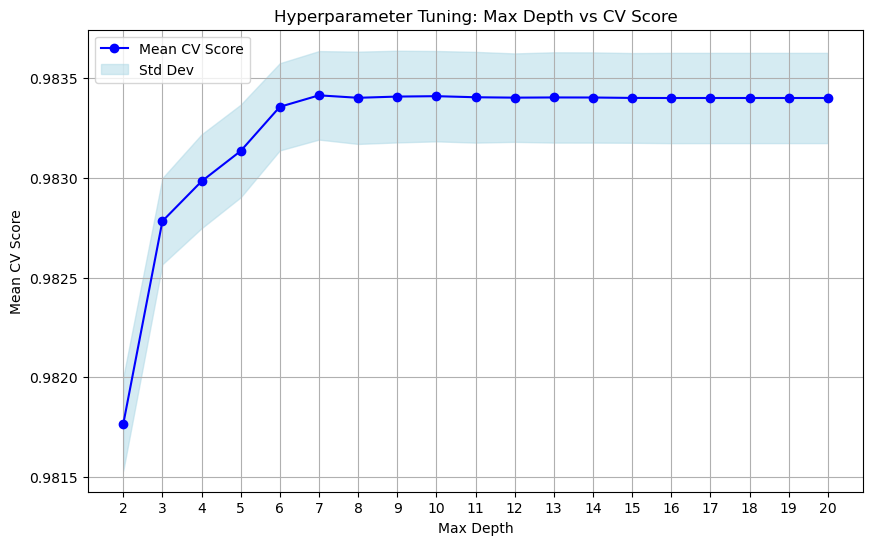

Fitting the final model with optimal max_depth = 7...

Model fitting complete.

Generating classification report and confusion matrix...


### Classification Report of LightGBM (Best Max Depth)

,Classifier,Model Definition,Class 0 - Precision,Class 0 - Recall,Class 0 - F1-Score,Class 1 - Precision,Class 1 - Recall,Class 1 - F1-Score,Average - Precision,Average - Recall,Average - F1-Score,Accuracy,Confusion Matrix
0,LightGBM,"LGBMClassifier(learning_rate=0.05, max_depth=7...",0.99692,0.969826,0.983186,0.970624,0.997003,0.983637,0.983772,0.983415,0.983412,0.983415,"[[21296239, 662588], [65805, 21893022]]"


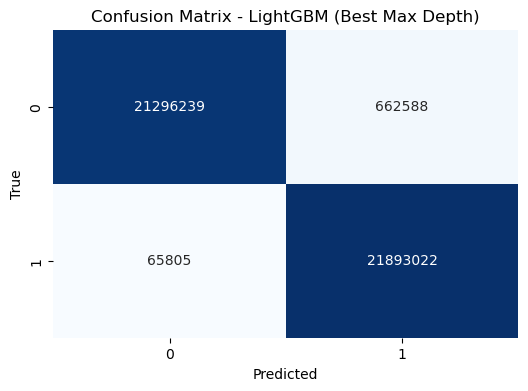

Model trained with optimal max_depth: 7, achieving best CV score of: 98.34%


In [9]:
def light_gbm(lgbm_learning_rate, num_leaves, df_norm):
    # Define the features and target
    X = df_norm.drop(columns=['Burn_Label'])
    Y = df_norm['Burn_Label']
    
    max_depth_range = range(2, 21)  # Range of max_depth to test (2 to 20)
    cv_scores = []  # Store mean cross-validation scores
    cv_std_devs = []  # Store standard deviation of cross-validation scores
    
    print("Performing hyperparameter tuning for max_depth in range 2-20...")
    
    for max_depth in max_depth_range:
        params = {
            'verbose': -1,
            'learning_rate': lgbm_learning_rate,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'max_depth': max_depth,
            'num_leaves': num_leaves
        }
        
        # Initialize the LightGBM model
        lgbm_model = LGBMClassifier(**params)
        
        # 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        lgbm_scores = cross_val_score(lgbm_model, X, Y, cv=kf)
        
        # Store the mean and std of cross-validation scores
        cv_scores.append(lgbm_scores.mean())
        cv_std_devs.append(lgbm_scores.std())
        
        print(f"Max Depth: {max_depth}, CV Score: {round(lgbm_scores.mean() * 100, 2)}%, Std Dev: {round(lgbm_scores.std() * 100, 2)}%")
    
    # Find the optimal max_depth based on highest mean CV score
    optimal_index = np.argmax(cv_scores)
    optimal_max_depth = max_depth_range[optimal_index]
    best_cv_score = cv_scores[optimal_index]
    
    print(f"\nOptimal Max Depth: {optimal_max_depth} with CV Score: {round(best_cv_score * 100, 2)}%")
    
    # Plot the cross-validation results
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_range, cv_scores, marker='o', linestyle='-', color='b', label='Mean CV Score')
    plt.fill_between(max_depth_range, 
                     np.array(cv_scores) - np.array(cv_std_devs), 
                     np.array(cv_scores) + np.array(cv_std_devs), 
                     color='lightblue', alpha=0.5, label='Std Dev')
    plt.title('Hyperparameter Tuning: Max Depth vs CV Score')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean CV Score')
    plt.xticks(max_depth_range)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    # Fit the model with the optimal max_depth
    print(f"Fitting the final model with optimal max_depth = {optimal_max_depth}...")
    final_params = {
        'verbose': -1,
        'learning_rate': lgbm_learning_rate,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': optimal_max_depth,
        'num_leaves': num_leaves
    }
    
    lgbm_model = LGBMClassifier(**final_params)
    lgbm_model.fit(X, Y)
    
    print("\nModel fitting complete.")
    
    # Generate classification report and confusion matrix
    print("\nGenerating classification report and confusion matrix...")
    y_pred = cross_val_predict(lgbm_model, X, Y, cv=kf)
    report = classification_report(Y, y_pred, output_dict=True)
    cm = confusion_matrix(Y, y_pred)
    
    # Create a summary of the results
    lgbm_result = [{
        'Classifier': 'LightGBM',
        'Model Definition': lgbm_model,
        'Class 0 - Precision': report['0']['precision'],
        'Class 0 - Recall': report['0']['recall'],
        'Class 0 - F1-Score': report['0']['f1-score'],
        'Class 1 - Precision': report['1']['precision'],
        'Class 1 - Recall': report['1']['recall'],
        'Class 1 - F1-Score': report['1']['f1-score'],
        'Average - Precision': report['macro avg']['precision'],
        'Average - Recall': report['macro avg']['recall'],
        'Average - F1-Score': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy'],
        'Confusion Matrix': cm
    }]
    
    lgbm_result_df = pd.DataFrame(lgbm_result)
    
    display(Markdown("### Classification Report of LightGBM (Best Max Depth)"))
    display(lgbm_result_df)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - LightGBM (Best Max Depth)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return lgbm_model, optimal_max_depth, best_cv_score

# Call the function with the parameters and your DataFrame
lgbm_model, optimal_max_depth, best_cv_score = light_gbm(0.05, 31, df_norm)

print(f"Model trained with optimal max_depth: {optimal_max_depth}, achieving best CV score of: {round(best_cv_score * 100, 2)}%")

### Export LightGBM Model as pickle

After training the LightGBM model, the following code is used to save the trained model to disk for future use:

1. **Define Save Path**:
   - `savepath = r'Export_Model'`: This line sets the directory path where the trained model will be saved. The path is a string and points to a folder named `Export_Model`.

2. **Create File Path for the Model**:
   - `lgbm_filename_model = os.path.join(savepath, 'Model_LGBM.sav')`: This line creates the full path to save the model. It combines the `savepath` directory with the filename `Model_LGBM.sav`.

3. **Save the Model Using Pickle**:
   - `pickle.dump(lgbm_model, open(lgbm_filename_model, 'wb'))`: The `pickle.dump()` function is used to serialize the trained LightGBM model (`lgbm_model`) and save it to the file `Model_LGBM.sav`. The model is saved in binary mode (`'wb'`) to ensure that it can be loaded later for inference or further analysis.

This process allows you to persist the trained model and easily load it later without having to retrain it.

In [10]:
savepath = r'Export_Model'
lgbm_filename_model = os.path.join(savepath, 'Model_LGBM.sav')
pickle.dump(lgbm_model, open(lgbm_filename_model, 'wb'))

### XGBoost Model Training

The `xgboost_model` function performs hyperparameter tuning for the XGBoost model to find the optimal `max_depth` and evaluate its performance using cross-validation. GPU processing is enabled to speed up the training process. Below is a breakdown of the steps involved:

1. **Input Parameters**:
   - `df`: The DataFrame containing the dataset with the target variable `Burn_Label`.
   - `xgb_estimator_num`: The number of estimators (trees) for the XGBoost model, default value is 100.
   - `objective`: The objective function for the model, default value is `"binary:logistic"` for binary classification.

2. **Data Preparation**:
   - The target variable (`Burn_Label`) is separated from the features, and the feature matrix (`X`) and target vector (`Y`) are defined.

3. **Cross-Validation Setup**:
   - A 10-fold cross-validation strategy (`KFold`) is used to split the data into training and validation sets for robust evaluation of the model.

4. **Hyperparameter Tuning**:
   - The function iterates through different values of `max_depth` (ranging from 2 to 20), training an XGBoost model with each `max_depth` value.
   - For each value of `max_depth`, the model is evaluated using cross-validation, and the mean cross-validation accuracy is stored.

5. **GPU Acceleration**:
   - GPU processing is enabled by using the `tree_method="gpu_hist"` and `predictor="gpu_predictor"` parameters for both training and prediction. This significantly accelerates the model training and prediction times.

6. **Plotting Results**:
   - A plot is generated to visualize the relationship between `max_depth` and mean cross-validation accuracy. This helps in identifying the optimal `max_depth` for the best model.

7. **Optimal Model Training**:
   - Once the best `max_depth` is identified, the final model is trained with the optimal hyperparameters, and cross-validation is performed again to calculate the mean and standard deviation of the accuracy.

8. **Model Evaluation**:
   - A classification report and confusion matrix are generated to evaluate the model's performance in terms of precision, recall, F1-score, and overall accuracy.
   - A confusion matrix heatmap is plotted to provide a clear visualization of the model's predictions versus the actual outcomes.

9. **Output**:
   - The function returns the best-trained XGBoost model (`xgb_model_best`), along with the mean and standard deviation of the cross-validation scores.

10. **Example Usage**:
   - The function is called with a dataset (`df_norm`), and it performs hyperparameter tuning and evaluation of the XGBoost model using GPU acceleration.

This approach leverages GPU resources for faster training while optimizing model performance based on cross-validation results, making it suitable for large datasets and efficient model selection.

GPU available: True


### Hyperparameter Tuning for XGBoost

c:\Users\admin\anaconda3\envs\RIDA_env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Max Depth: 2, CV Score: 98.33%, Std Dev: 0.01%
Max Depth: 3, CV Score: 98.34%, Std Dev: 0.01%
Max Depth: 4, CV Score: 98.37%, Std Dev: 0.01%
Max Depth: 5, CV Score: 98.38%, Std Dev: 0.01%
Max Depth: 6, CV Score: 98.39%, Std Dev: 0.01%
Max Depth: 7, CV Score: 98.4%, Std Dev: 0.01%
Max Depth: 8, CV Score: 98.41%, Std Dev: 0.01%
Max Depth: 9, CV Score: 98.42%, Std Dev: 0.01%
Max Depth: 10, CV Score: 98.42%, Std Dev: 0.01%
Max Depth: 11, CV Score: 98.43%, Std Dev: 0.01%
Max Depth: 12, CV Score: 98.44%, Std Dev: 0.01%
Max Depth: 13, CV Score: 98.44%, Std Dev: 0.01%
Max Depth: 14, CV Score: 98.45%, Std Dev: 0.01%
Max Depth: 15, CV Score: 98.45%, Std Dev: 0.01%
Max Depth: 16, CV Score: 98.45%, Std Dev: 0.01%
Max Depth: 17, CV Score: 98.46%, Std Dev: 0.01%
Max Depth: 18, CV Score: 98.46%, Std Dev: 0.01%
Max Depth: 19, CV Score: 98.47%, Std Dev: 0.01%
Max Depth: 20, CV Score: 98.47%, Std Dev: 0.01%
Best Max Depth: 20 with Mean CV Accuracy: 98.47%


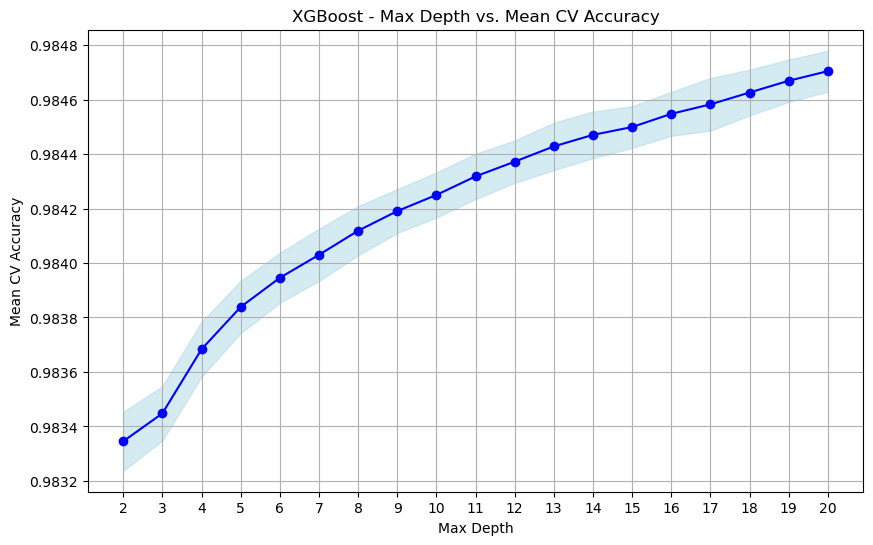

XGBoost (Best Max Depth = 20) Cross-validation scores: 98.47%
XGBoost (Best Max Depth = 20) Standard deviation: 0.01%


### Classification Report of XGBoost (Best Max Depth)

,Classifier,Model Definition,Class 0 - Precision,Class 0 - Recall,Class 0 - F1-Score,Class 1 - Precision,Class 1 - Recall,Class 1 - F1-Score,Average - Precision,Average - Recall,Average - F1-Score,Accuracy,Confusion Matrix
0,XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.997488,0.971856,0.984505,0.972561,0.997553,0.984899,0.985025,0.984705,0.984702,0.984705,"[[21340821, 618006], [53735, 21905092]]"


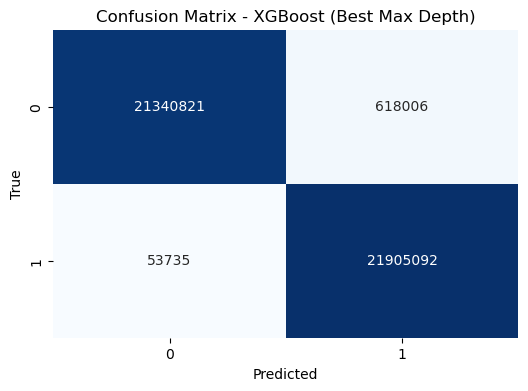

<span style='color: green; font-weight: bold;'>XGBoost Model Run Complete (GPU/CPU Enabled)</span>

In [11]:
def xgboost_model(df_norm, xgb_estimator_num=100, objective="binary:logistic"):
    """
    Performs hyperparameter tuning for XGBoost to find optimal max_depth
    and plots the results with GPU or CPU processing.
    
    Parameters:
    -----------
    df_norm : pandas.DataFrame
        Input dataframe containing features and target variable
    xgb_estimator_num : int, optional (default=100)
        Number of estimators for XGBoost
    objective : str, optional (default="binary:logistic")
        Objective function for XGBoost
    
    Returns:
    --------
    tuple: (best_xgb_model, mean_cross_val_score, std_cross_val_score)
    """
    # Check if GPU is available
    def is_gpu_available():
        try:
            test_model = XGBClassifier(tree_method="gpu_hist")
            return "gpu_hist" in test_model.get_xgb_params().get("tree_method", "")
        except:
            return False

    gpu_available = is_gpu_available()
    if gpu_available:
        print(f"GPU available: {gpu_available}")
    else:
        print(f"GPU unavailable, CPU Enabled.")

    display(Markdown("### Hyperparameter Tuning for XGBoost"))
    print()  # Add Blank Line

    # Define the features and target
    X = df_norm.drop(columns=['Burn_Label'])  # Features: all columns except Burn_Label
    Y = df_norm['Burn_Label']                 # Target: Burn_Label column

    # Set up cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-fold cross-validation
    
    max_depths = list(range(2, 21))  # Range of max_depth to test
    mean_cv_scores = []
    cv_std_devs = []

    # Perform hyperparameter tuning
    for max_depth in max_depths:
        xgb_model = XGBClassifier(
            n_estimators=xgb_estimator_num,
            max_depth=max_depth,
            objective=objective,
            eval_metric="logloss",
            random_state=42,
            tree_method="hist",  # Use "hist" for both CPU and GPU
            device="cuda" if gpu_available else "cpu"  # Explicitly set device
        )
        try:
            scores_cv = cross_val_score(xgb_model, X, Y, cv=kf, scoring='accuracy')
            mean_cv_scores.append(scores_cv.mean())
            cv_std_devs.append(scores_cv.std())
            print(f"Max Depth: {max_depth}, CV Score: {round(scores_cv.mean() * 100, 2)}%, Std Dev: {round(scores_cv.std() * 100, 2)}%")
        except Exception as e:
            print(f"Error processing max_depth {max_depth}: {e}")
            mean_cv_scores.append(0)
            
    # Find the best max_depth
    best_max_depth = max_depths[np.argmax(mean_cv_scores)]
    best_accuracy = max(mean_cv_scores)
    print(f"Best Max Depth: {best_max_depth} with Mean CV Accuracy: {round(best_accuracy * 100, 2)}%")

    # Plotting the mean cross-validation accuracy vs. max_depth
    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, mean_cv_scores, marker='o', linestyle='-', color='blue')
    plt.fill_between(
        max_depths, 
        np.array(mean_cv_scores) - np.array(cv_std_devs), 
        np.array(mean_cv_scores) + np.array(cv_std_devs), 
        color='lightblue', alpha=0.5, label='Std Dev'
    )
    plt.xlabel('Max Depth')
    plt.ylabel('Mean CV Accuracy')
    plt.title('XGBoost - Max Depth vs. Mean CV Accuracy')
    plt.xticks(max_depths)
    plt.grid(True)
    plt.show()

    # Train and evaluate XGBoost with the best max_depth
    xgb_model_best = XGBClassifier(
        n_estimators=xgb_estimator_num,
        max_depth=best_max_depth,
        objective=objective,
        eval_metric="logloss",
        random_state=42,
        tree_method="hist",  # Use "hist" for both CPU and GPU
        device="cuda" if gpu_available else "cpu"  # Explicitly set device
    )
    xgb_model_best.fit(X, Y)
    scores_cv = cross_val_score(xgb_model_best, X, Y, cv=kf, scoring='accuracy')
    mean_cv = scores_cv.mean()
    std_cv = scores_cv.std()

    # Display Cross-validation results
    print(f"XGBoost (Best Max Depth = {best_max_depth}) Cross-validation scores: {round(mean_cv * 100, 2)}%")
    print(f"XGBoost (Best Max Depth = {best_max_depth}) Standard deviation: {round(std_cv * 100, 2)}%")
    
    # Generate classification report
    y_pred = cross_val_predict(xgb_model_best, X, Y, cv=kf)
    report = classification_report(Y, y_pred, output_dict=True)
    cm = confusion_matrix(Y, y_pred)
    
    xgb_result = [{
        'Classifier': 'XGBoost',
        'Model Definition': xgb_model_best,
        'Class 0 - Precision': report['0']['precision'],
        'Class 0 - Recall': report['0']['recall'],
        'Class 0 - F1-Score': report['0']['f1-score'],
        'Class 1 - Precision': report['1']['precision'],
        'Class 1 - Recall': report['1']['recall'],
        'Class 1 - F1-Score': report['1']['f1-score'],
        'Average - Precision': report['macro avg']['precision'],
        'Average - Recall': report['macro avg']['recall'],
        'Average - F1-Score': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy'],
        'Confusion Matrix': cm
    }]
    
    xgb_result_df = pd.DataFrame(xgb_result)
    
    display(Markdown("### Classification Report of XGBoost (Best Max Depth)"))
    display(xgb_result_df)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - XGBoost (Best Max Depth)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print()  # Add Blank Line
    display(Markdown("<span style='color: green; font-weight: bold;'>XGBoost Model Run Complete (GPU/CPU Enabled)</span>"))
    print()  # Add Blank Line

    return xgb_model_best, mean_cv, std_cv

# Call the xgboost_model function with the desired parameters and your DataFrame
xgb_model_best, mean_cv_best, std_cv_best = xgboost_model(df_norm)

### Export XGBoost as pickle

After training the XGBoost model with the optimal hyperparameters, the model is saved to a file for later use. The following steps are involved in saving the trained model:

1. **Define Save Path**:
   - The variable `savepath` is set to a directory called `'Export_Model'`, where the model will be saved. If the directory does not exist, it should be created manually or via additional code.

2. **Create the File Path**:
   - `xgb_filename_model` constructs the full file path for saving the model. The model file will be named `Model_XGB.sav` and will be stored in the `Export_Model` directory.

3. **Save the Model**:
   - The `pickle.dump` function is used to serialize and save the trained XGBoost model (`xgb_model_best`) to the specified file path. The file is saved in binary format using the `wb` mode.

4. **Usage**:
   - This allows the trained model to be loaded later for predictions or further analysis without needing to retrain it.

By saving the model, you can easily load it in the future for inference or to integrate it into a production environment.

In [12]:
savepath = r'Export_Model'
xgb_filename_model = os.path.join(savepath, 'Model_XGB.sav')
pickle.dump(xgb_model_best, open(xgb_filename_model, 'wb'))